# Eye Fixation Prediction in Digital Images
Benjamin Jafek <br>
Dec 2, 2017

In [17]:
import pandas as pd
from matplotlib import pyplot as plt

I seek to study eye-tracking data to answer the question, “How do people filter out unnecessary information in digital images?” I have eye-tracking data from a large group of volunteers who were given two separate tasks, a scene viewing task and a visual search task. I anticipate that these findings will not only provide insight into cognitive vision, but also suggest sampling techniques for computer vision algorithms. I will test my findings on state-of-the-art computer vision algorithms, comparing accuracy and speed between baseline and sampled images.
<img style="float: right;width:500px;height:300px;" align="right" src="licenseplate_eyetrack.png">
<br> <br>
Despite the recent leaps and bounds in recent computer vision abilities, computers are still far outpaced by the human visual system. With vision being our primary sensory input, we humans each develop the ability to effortlessly create full visual fields from relatively small amounts of information. Is there not something which computers can learn from this exemplary system? The field of computational cognition has recently begun exploring this fascinating question. In fact, this past October, a conference entitled ‘Mutual Benefits of Cognitive and Computer Vision’  took place in Venice, Italy, with researchers from all over the world presenting on topics such as “What are the visual features underlying human versus machine vision?” [1], “Evaluation of deep learning on an abstract image classification dataset” [2], and “Can we speed up 3D scanning? A cognitive and geometric analysis” [3]. In my project, I hope to continue this exciting trend. The long-term purpose of this project is to explore how human data can be used to improve the efficiency of DCNs.

**This dataset required a lot of feature engineering.** <br><br>
The features of the original dataset were things like 'current x fixation', 'current y fixation', 'saccade length', and 'saccade angle': features describing the coordinates of the eye fixation. This information is helpful, but certainly nothing that you could feed into a learning algorithm and hope to get meaningful results from. <br>
First, we must ask 'Are eye fixations a good measure of visual attention? Is it both necessary and sufficient to fixate the eye on a location in order to attend to it?' This is a very interesting question. The answer is that we're not completely sure, but it has been found to be the best proxy for attention [1]. Alternatively, we could maybe hook up an electroencephalogram to the patient, but even then, modern science is not entirely sure what the brain mechanisms are that correspond to visual attention [2]. Thus, we will assume that eye fixations are necessary and sufficient conditions for visual attention for the remainder of this project. We also assume that the volunteers are entirely homogeneous in their visual preferences.
For my features, I looked at low-level features of the image in a neighborhood near the eye fixation. I let this neighborhood be a ball of radius 75 pixels, which corresponds pretty well to how much peripheral vision you have when you are focusing on a single point. <br>
Thus, I had a lot of images that looked something like this, where the red ball is centered at the human eye fixation:
<center><img style="float: center;width:800px;height:300px;" align="right" src="cutout.png"></center>

### For this specific project, I plan to develop a model that can predict eye fixations in an image.
Now, deciding where to look in a scene requires a very high-level understanding of the scene. For example, in the above image, bicycles and cars are more interesting than piles of snow and roads. However, there is no 'bicycle' feature that I could extract from this image. Well, there is, but it requires many layers of a deep neural network to extract [6]. The whole point of this project is to develop some model of human visual attention (which generally relies on high-level understanding) using low-level features of the image.  
Thus, my hypothesis is that some combination of low-level data will correlate with visual attention strongly enough that we can predict eye fixations on a novel image.  
The features that I chose to extract from the localized image are:  

1. Picture name
2. X center (of localization)
3. Y center (of localization
4. Brightness (calculated by the mean value of the V channel in a HSV image).
5. Contrast (RMS).
6. Focus measure - basically 'how blurry the image is' - (calculated by the variance of the Laplacian transform [7]). 
7. RMS contrast on the vertical edges (Sobel X edge detector)
8. Focus measure on the vertical edges (Sobel X edge detector)
9. RMS contrast on the horizontal edges (Sobel Y edge detector)
10. Focus measure on the horizontal edges (Sobel Y edge detector) <br>
11. Red pixels (% of total)
12. Green pixels (% of total)
13. Blue pixels (% of total)
14. Indoor/outdoor
15. Fixation at this location? (Y/N) **label**

I iterated through every 5 pixels (i.e., 0,5,10,...,800) of each of the 32 images, and gathered these 11 features at each point. The 'label' of the data will be EYE FIXATION: Y/N. 
<img style="float: left;width:300px;height:200px;PADDING-RIGHT:10px;PADDING_TOP:10px;" align="right" src="attic.jpg">
I anticipate that using this information, we will be able to accurately predict the eye fixations of a person given a novel image. <br>

If we can manage that, then we'll have a good way of modeling high-level visual decisions using low-level image features. That would be exciting. I will continue to search for other low-level properties of images to feed into my model, but for now, these are the ones that I have. Notice that the 14th feature, indoor/outdoor, is a high-level property of the image, and will be hand-labeled. This is, of course, cheating, but it is a very easy label, and should be knowable information in real-world applications. In the table below, the image is of an attic, so it is indoors, so the 'Outdoor' boolean variable is False, corresponding to a 0.

Below is listed the CSV corresponding to the image to the left:

In [21]:
df = pd.read_csv('../FULLCSVs/attic.csv', index_col=False)
df.head()

,Picture,X_center,Y_center,Brightness,Contrast,FM,VerticalContrast,VerticalFM,HorizontalContrast,HorizontalFM,Outdoor,Blue,Green,Red,Total
0,attic.jpg,0,0,0.000206,0.002277,0.007155,0.031867,3.400914,0.030676,4.938998,0,0.324017,0.330211,0.345772,1294570
1,attic.jpg,0,5,0.000208,0.002203,0.006928,0.030702,3.615816,0.028437,4.945617,0,0.323588,0.330003,0.346409,1414482
2,attic.jpg,0,10,0.000211,0.002146,0.007204,0.030357,3.715107,0.027904,4.993102,0,0.323025,0.330075,0.346900,1540524
3,attic.jpg,0,15,0.000212,0.002090,0.006742,0.029232,3.655078,0.026608,4.859082,0,0.322190,0.329585,0.348225,1664647
4,attic.jpg,0,20,0.000213,0.002031,0.006820,0.028192,3.668993,0.024983,4.775179,0,0.321549,0.328777,0.349674,1779742


# Data Analysis
<center><img style="float: center;width:400px;height:300px;" align="right" src="image_gradients.png"></center>
As mentioned above, two image processing techniques I used to analyze the images were
(1) the Laplacian operator, and (2) the Sobel Edge detector. Both of these techniques basically simplify the image down to just the edges, so that we can analyze the edges better. The Laplacian operator is used to calculate focus measure. Notice that the Sobel X edge detector leaves only vertical lines, and the Sobel Y detector leaves only horizontal lines. This allows us to analyze vertical and horizontal lines separately.
<br> <br> <br><br> <br> <br><br> <br> <br>

<center><img style="float: center;width:600px;height:400px;" align="right" src="rgb_ims.png"></center>
Next, I split the image into its Red, Green, and Blue channels. To the right we see the attic.jpg image. Since the image is comprised of all colors of the spectrum and not just RGB, it is difficult to tell exactly which colors contribute to which shade of brown in the attic. In fact, most of the percentages of RGB remain right around 33% for each. However, there are some outliers. The below images show the most Red, Green, and Blue segments of the image, respectively.

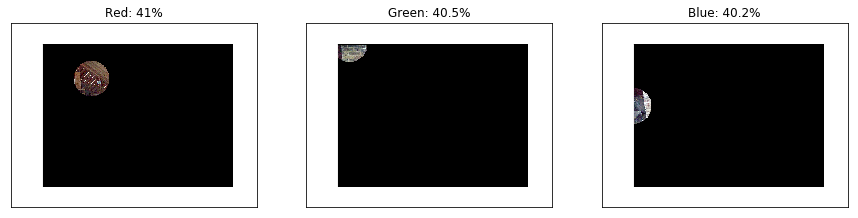

In [25]:
rimg, grimg, blimg = plt.imread('red_img.png'), plt.imread('green_img.png'), plt.imread('blue_img.png')
plt.figure(figsize=(15,12))
plt.subplot(131)
plt.imshow(rimg)
plt.title('Red: 41%')
plt.yticks([])
plt.xticks([])
plt.subplot(132)
plt.imshow(grimg)
plt.title('Green: 40.5%')
plt.yticks([])
plt.xticks([])
plt.subplot(133)
plt.imshow(blimg)
plt.title('Blue: 40.2%')
plt.yticks([])
plt.xticks([])
plt.show()

### Now for the most interesting part of the project, the eye fixation heat map. 
These heatmaps were created using a Gaussian-blurred intensity matrix.
<br><br>
We notice in the first image of the locker room, that most people focus on the most visually interesting object, the equipment bag in the middle of the room. I hope that the low-level aspects of the image near the equipment bag reveal something distinguishing about it.
<br><br>
In the second image of the dining room, it is more difficult to extract any immediate conclusions about how the volunteers decided to look at the locations that they did. In this case, it will be even more interesting to see if a machine learning model can find a pattern between all of these locations.

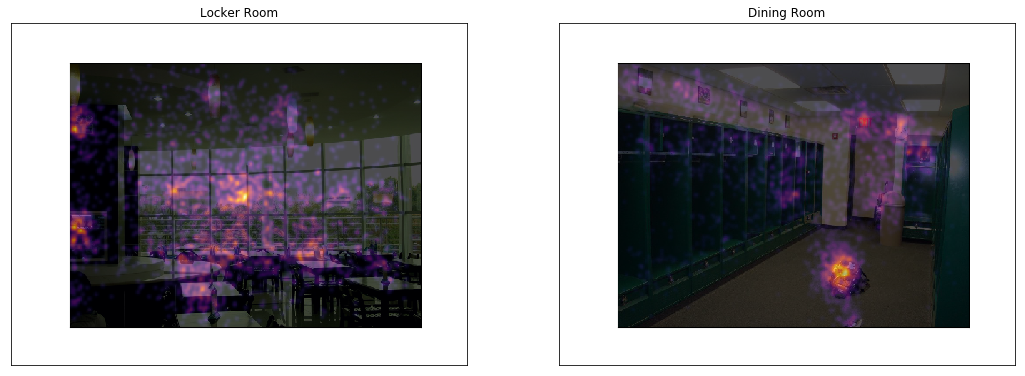

In [29]:
dining, locker = plt.imread('diningroom_heatmap.png'), plt.imread('lockerroom_heatmap.png')
plt.figure(figsize=(18,12))
plt.subplot(121)
plt.imshow(dining)
plt.title('Locker Room')
plt.yticks([])
plt.xticks([])
plt.subplot(122)
plt.imshow(locker)
plt.title('Dining Room')
plt.yticks([])
plt.xticks([])
plt.show()

## Sources
1.	D. Linsley, S. Eberhardt, T. Sharma, P. Gupta, T. Serre. “What are the visual features underlying human versus machine vision?” _Mutual Benefits of Cognitive and Computer Vision_. 2017.
2.	S. Stabinger, A. Rodriguez. “Evaluation of Deep Learning on an Abstract Image Classification Dataset.” _Mutual Benefits of Cognitive and Computer Vision_. 2017.
3.	K. Vaiapury, B. Purushothaman, A. Pal, S. Agarwal. “Can we speed up 3D scanning? A cognitive and geometric analysis.” _Mutual Benefits of Cognitive and Computer Vision_. 2017.
4. Hoffman, J. and Subramaniam, B. "The role of visual attention in saccadic eye movements." _Perception & Psychophysics_, 1995. <br>
5. Busch, N. and VanRullen, R. "Spontaneous EEG oscillations reveal periodic sampling of visual attention." _Psychological and Cognitive Sciences_, 2010. <br>
6. Zhou, B., Khosla, A., Lapedriza, A., Oliva,  A., and Torralba, A. "Learning Deep Features for Discriminative Localization." _CVPR_, 2016. <br>
7. Pertuz, S., Puig, D., and Garcia, M. "Analysis of focus measure operators for shape-from-focus." _Pattern Recognition_, 2013.